In [3]:
import os
import json
import glob
import re
import sys
from typing import Dict, List

import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#import chart_studio
#from chart_studio import plotly as py

from IPython.display import display, clear_output, HTML

sys.path.append("..")
from utils.data_processing import (
    load_edge_scores_into_dictionary,
    compute_weighted_jaccard_similarity,
    compute_node_jaccard_similarity,
    compute_jaccard_similarity,
    compute_weighted_jaccard_similarity_to_reference,
    compute_ewma_weighted_jaccard_similarity,
    generate_in_circuit_df_files,
    load_node_dictionary,
    convert_checkpoint_steps_to_tokens
)

ModuleNotFoundError: No module named 'plotly'

In [3]:
from typing import List, Optional, Tuple, Union

import torch
from torch import Tensor
import numpy as np
import pandas as pd
import yaml
from typing import Tuple, List, Dict

## Plot Jaccard

In [3]:
in_circuit_df = pd.read_feather(f'/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/sva/in_circuit_edges_faithful.feather')
weighted_jaccard_results =compute_jaccard_similarity(in_circuit_df)

In [6]:
print(weighted_jaccard_results)

    checkpoint_1  checkpoint_2  jaccard_similarity
0              2            16            0.129032
1             16           256            0.145161
2            256           512            0.525000
3            512          1000            0.466667
4           1000          2000            0.775000
5           2000          3000            0.826087
6           3000          4000            0.711864
7           4000          5000            0.776119
8           5000          6000            0.797101
9           6000          7000            0.788732
10          7000          8000            0.736111
11          8000          9000            0.718310
12          9000         10000            0.725000
13         10000         11000            0.780488
14         11000         12000            0.773333
15         12000         13000            0.823529
16         13000         14000            0.869565
17         14000         15000            0.830986
18         15000         20000 

In [10]:
span = len(weighted_jaccard_results )
ewma = weighted_jaccard_results["jaccard_similarity"].ewm(span=span, adjust=False).mean()
weighted_jaccard_results["jaccard_similarity"] = ewma
print(weighted_jaccard_results)

    checkpoint_1  checkpoint_2  jaccard_similarity
0              2            16            0.129032
1             16           256            0.129904
2            256           512            0.151261
3            512          1000            0.168310
4           1000          2000            0.201104
5           2000          3000            0.234887
6           3000          4000            0.260669
7           4000          5000            0.288531
8           5000          6000            0.316022
9           6000          7000            0.341574
10          7000          8000            0.362900
11          8000          9000            0.382111
12          9000         10000            0.400646
13         10000         11000            0.421178
14         11000         12000            0.440213
15         12000         13000            0.460933
16         13000         14000            0.483021
17         14000         15000            0.501830
18         15000         20000 

In [6]:
color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

In [7]:
def generate_in_circuit_jaccard(
        graphs_folder: str,
        core_models,
        task: str,
        start_checkpoint: int = 1000, 
    ) -> None:
    list_of_df = {}
    for model in core_models:
        try:
            model_folder_path = os.path.join(graphs_folder, model)
            task_path = os.path.join(model_folder_path, task)
            if task == "ioi":
                path = os.path.join(task_path, "in_circuit_edges.feather")
            else:
                path = os.path.join(task_path, "in_circuit_edges_faithful.feather")
            print(path)
            in_circuit_df = pd.read_feather(path)
            weighted_jaccard_results = compute_jaccard_similarity(in_circuit_df)
            span = len(weighted_jaccard_results )
            ewma = weighted_jaccard_results["jaccard_similarity"].ewm(alpha = 0.5, adjust=False).mean()
            weighted_jaccard_results["jaccard_similarity"] = ewma
            list_of_df[model] = weighted_jaccard_results 
        except:
            continue
    
    for model in core_models:
        try:
            mask = list_of_df[model]['checkpoint_1'].isin(ckpts)
            list_of_df[model] = list_of_df[model][mask]
        except:
            continue
    return list_of_df


In [5]:
ckpts = [i * 1000 for i in range(1, 16)] + [i * 5000 for i in range(3, 14)] + [i * 10000 for i in range(7, 15)]

In [15]:
print(ckpts)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000]


In [16]:
baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'gender_pronoun')
print(baselines)

/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/gender_pronoun/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/gender_pronoun/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/gender_pronoun/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/gender_pronoun/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/gender_pronoun/in_circuit_edges_faithful.feather
{'pythia-70m':     checkpoint_1  checkpoint_2  jaccard_similarity
5           1000          2000            0.684785
6           2000          3000            0.694244
7           3000          4000            0.756213
8           4000          5000            0.711440
9           5000          6000            0.855720
10          6000          7000            0.861193
11          7000          8000            0.897263
12          8000          9000            0.9152

In [3]:
import torch
from pathlib import Path 
import json 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

plt.rcParams["font.family"] = 'DejaVu Serif'

fig, axs = plt.subplots(2,2)
fig.set_size_inches(11, 5)
baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'ioi')
for k, baseline in baselines.items():
    axs[0,0].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['jaccard_similarity'], label=k, c=color_palette[k])

axs[0,0].set_title('Indirect Object Identification')
axs[0,0].set_ylabel('Weighted Jaccard Similarity')
axs[0,0].set_ylim(0, 1)

baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'gender_pronoun')
for k, baseline in baselines.items():
    axs[0,1].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['jaccard_similarity'], label=k, c=color_palette[k])

axs[0,1].set_title('Gender Pronoun')
axs[0,1].set_ylim(0, 1)

baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'greater_than')
for k, baseline in baselines.items():
    axs[1,0].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['jaccard_similarity'], label=k, c=color_palette[k])

axs[1,0].set_title('Greater-Than')
axs[1,0].set_ylabel('Weighted Jaccard Similarity')
axs[1,0].set_xlabel('#Training Tokens')
axs[1,0].set_ylim(0, 1)

baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'sva')
for k, baseline in baselines.items():
    axs[1,1].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['jaccard_similarity'], label=k, c=color_palette[k])
axs[1,1].set_title('SVA')
axs[1,1].set_xlabel('#Training Tokens')
axs[1,1].set_ylim(0, 1)

def first_digit(x, pos):
    return str(x)[0]

for ax in axs.flat:
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_minor_formatter(FuncFormatter(first_digit))
    ax.xaxis.set_tick_params(which='major', pad=10)

handles, labels = axs[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=5)
fig.show()
fig.tight_layout()


NameError: name 'generate_in_circuit_jaccard' is not defined

Error in callback <function flush_figures at 0x7f3904a5fe50> (for post_execute):


KeyboardInterrupt: 

In [ ]:
baselines = generate_in_circuit_jaccard('/mnt/hdd-0/circuits-over-time/results/graphs', core_models, 'sva')
print(baselines['pythia-410m'])

/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/sva/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/sva/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/sva/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/sva/in_circuit_edges_faithful.feather
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/sva/in_circuit_edges_faithful.feather
     checkpoint_1  checkpoint_2  jaccard_similarity
0            1000          2000            0.401032
1            2000          3000            0.709181
2            3000          4000            0.823032
3            4000          5000            0.811731
4            5000          6000            0.849157
5            6000          7000            0.863345
6            7000          8000            0.828947
7            8000          9000            0.834791
8            9000         10000            0.829678
9     

## Plot Edges

In [ ]:
from typing import List, Optional, Tuple, Union

import torch
from torch import Tensor
import numpy as np
import pandas as pd
import yaml
from typing import Tuple, List, Dict

In [ ]:
def generate_results_edge(model, TASK, start_checkpoint):
    list_of_df = {}
    for m in model:
        try:
            if TASK == 'ioi':
                in_circuit_df = pd.read_feather(f'/mnt/hdd-0/circuits-over-time/results/graphs/{m}/{TASK}/in_circuit_edges.feather')
            else:
                in_circuit_df = pd.read_feather(f'/mnt/hdd-0/circuits-over-time/results/graphs/{m}/{TASK}/in_circuit_edges_faithful.feather')
            edge_count_df = in_circuit_df.groupby('checkpoint').size().reset_index(name='num_edges')  
            in_circuit_df = edge_count_df[edge_count_df['checkpoint'] >= start_checkpoint]
            list_of_df[m] = edge_count_df
        except:
            continue
    return list_of_df

NameError: name 'generate_results_edge' is not defined

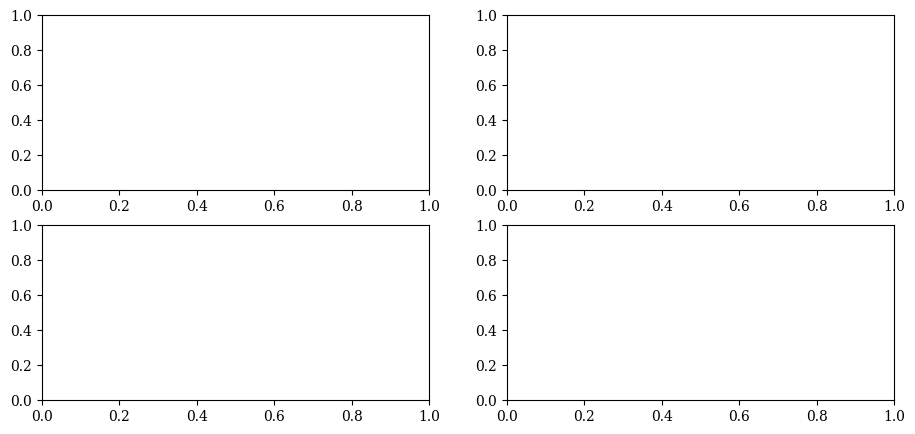

In [7]:
import torch
from pathlib import Path 
import json 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

plt.rcParams["font.family"] = 'DejaVu Serif'

fig, axs = plt.subplots(2,2)
fig.set_size_inches(11, 5)
baselines = generate_results_edge(core_models, 'ioi', 1000)
for k, baseline in baselines.items():
    axs[0,0].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['num_edges'], label=k, c=color_palette[k])

axs[0,0].set_title('Indirect Object Identification')
axs[0,0].set_ylabel('Num of Edges')

baselines = generate_results_edge(core_models, 'gender_pronoun', 1000)
for k, baseline in baselines.items():
    axs[0,1].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['num_edges'], label=k, c=color_palette[k])

axs[0,1].set_title('Gender Pronoun')

baselines = generate_results_edge(core_models, 'greater_than', 1000)
for k, baseline in baselines.items():
    axs[1,0].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['num_edges'], label=k, c=color_palette[k])

axs[1,0].set_title('Greater-Than')
axs[1,0].set_ylabel('Num of Edges')
axs[1,0].set_xlabel('Step')

baselines = generate_results_edge(core_models, 'sva', 1000)
for k, baseline in baselines.items():
    axs[1,1].plot(convert_checkpoint_steps_to_tokens(baseline['checkpoint_1']), baseline['num_edges'], label=k, c=color_palette[k])
axs[1,1].set_title('SVA')
axs[1,1].set_xlabel('Step')


def first_digit(x, pos):
    return str(x)[0]

for ax in axs.flat:
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_minor_formatter(FuncFormatter(first_digit))
    ax.xaxis.set_tick_params(which='major', pad=10)

handles, labels = axs[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)
fig.show()
fig.tight_layout()

# Plot Nodes

In [8]:
def generate_in_circuit_df_files(
        graphs_folder: str,
        task: str,
        start_checkpoint: int = 1, 
        limit_to_model: Optional[str] = None, 
        limit_to_task: Optional[str] = None
    ) -> None:
        for model_folder in os.listdir(graphs_folder):
                model_folder_path = os.path.join(graphs_folder, model_folder)
                if os.path.isdir(model_folder_path):  # Check if it's a directory
                        for task_folder in os.listdir(model_folder_path):
                                task_folder_path = os.path.join(model_folder_path, task_folder)
                                if task == "gender_pronoun":
                                        task_folder_path = os.path.join(task_folder_path, 'faithful')
                                # append the subfolder raw to the path
                                task_folder_path = os.path.join(task_folder_path, 'raw')
                                if os.path.isdir(task_folder_path): 
                                        if limit_to_model is not None and model_folder != limit_to_model:
                                                continue
                                        if limit_to_task is not None and task_folder != limit_to_task:
                                                continue
                                        if task == "gender_pronoun":
                                                folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/faithful/raw'
                                        else:
                                                folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/raw'
                                        if folder_path == f'{graphs_folder}/pythia-1.4b/sva/raw':
                                               folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/faithful/raw'
                                        if folder_path == f'{graphs_folder}/pythia-2.8b/sva/raw':
                                               folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/faithful/raw'
                                        dic = load_node_dictionary(folder_path)
                                        zero_dic = dic[dic['num_nodes'] == 0]
                                        return dic
                
        

In [ ]:
print(core_model)

In [11]:
correlation = {}
for i in core_models:
    correlation[i] = {}
    for j in ['ioi', 'greater_than', 'gender_pronoun', 'sva']:
        correlation[i][j] = 0
def generate_results_nodes(model, TASK, start_checkpoint):
    list_of_df = {}
    for m in model:
        in_circuit_df = generate_in_circuit_df_files('/mnt/hdd-0/circuits-over-time/results/graphs', task = TASK, start_checkpoint=1, limit_to_model=m, limit_to_task=TASK)       
        if in_circuit_df is not None:
            in_circuit_df = in_circuit_df[in_circuit_df['checkpoint'] >= start_checkpoint]
            list_of_df[m] = in_circuit_df  
            
            correlation[m][TASK] = in_circuit_df['checkpoint'].corr(in_circuit_df['num_nodes'])
    return list_of_df

In [13]:
import torch
from pathlib import Path 
import json 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

plt.rcParams["font.family"] = 'DejaVu Serif'

fig, axs = plt.subplots(2,2)
fig.set_size_inches(11, 5)
baselines = generate_results_nodes(core_models, 'ioi', 1000)
for k, baseline in baselines.items():
    axs[0,0].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[0,0].set_title('Indirect Object Identification')
axs[0,0].set_ylabel('Num of Nodes')

baselines = generate_results_nodes(core_models, 'gender_pronoun', 1000)
for k, baseline in baselines.items():
    axs[0,1].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[0,1].set_title('Gender Pronoun')

baselines = generate_results_nodes(core_models, 'greater_than', 1000)
for k, baseline in baselines.items():
    axs[1,0].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[1,0].set_title('Greater-Than')
axs[1,0].set_ylabel('Num of Nodes')
axs[1,0].set_xlabel('#Tokens Seen')

baselines = generate_results_nodes(core_models, 'sva', 1000)
for k, baseline in baselines.items():
    axs[1,1].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])
axs[1,1].set_title('SVA')
axs[1,1].set_xlabel('#Tokens Seen')


def first_digit(x, pos):
    return str(x)[0]

for ax in axs.flat:
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_minor_formatter(FuncFormatter(first_digit))
    ax.xaxis.set_tick_params(which='major', pad=10)

handles, labels = axs[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)
fig.show()
fig.tight_layout()


/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/gender_pronoun/faithful/raw


In [ ]:
print(correlation)

In [ ]:
load_node_dictionary('/mnt/hdd-0/circuits-over-time/results/faithfulness/pythia-410m/sva/faithfulness')